In [21]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import fbprophet
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import time

In [2]:
def import_data():
    raw_data_df=pd.read_csv("UKPN-LCL-smartmeter-sample.csv",header=0)
    return raw_data_df

result=import_data()
result.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC003718,Std,17/10/2012 13:00:00,0.09,ACORN-A,Affluent
1,MAC003718,Std,17/10/2012 13:30:00,0.16,ACORN-A,Affluent
2,MAC003718,Std,17/10/2012 14:00:00,0.212,ACORN-A,Affluent
3,MAC003718,Std,17/10/2012 14:30:00,0.145,ACORN-A,Affluent
4,MAC003718,Std,17/10/2012 15:00:00,0.104,ACORN-A,Affluent


In [3]:
result['date']=pd.to_datetime(result['DateTime'])

In [4]:
data=result.loc[:,['KWH/hh (per half hour) ']]

In [5]:
data=data.set_index(result.date)

In [6]:
data.head()

,KWH/hh (per half hour)
date,
2012-10-17 13:00:00,0.09
2012-10-17 13:30:00,0.16
2012-10-17 14:00:00,0.212
2012-10-17 14:30:00,0.145
2012-10-17 15:00:00,0.104


In [7]:
data['KWH/hh (per half hour) ']=pd.to_numeric(data['KWH/hh (per half hour) '],downcast='float',errors='coerce')

In [8]:
data.head()
data.dtypes

KWH/hh (per half hour)     float32
dtype: object

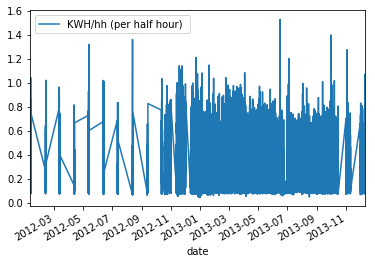

In [9]:
data.plot()

TypeError: float() argument must be a string or a number, not 'Period'

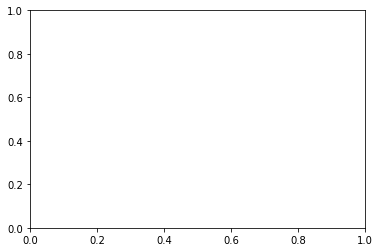

In [11]:
weekly=data.resample('W').sum()
weekly.plot(style=[':','--','-'])

In [ ]:
daily=data.resample('D').sum()
daily.rolling(30,center=True).sum().plot(style=[':','--','-'])

In [ ]:
by_time=data.groupby(data.index.time).mean()
hourly_ticks=4*60*60*np.arange(6)
by_time.plot(xticks=hourly_ticks,style=[':','--','-']);

In [ ]:
pd.plotting.autocorrelation_plot(data['KWH/hh (per half hour) '])

In [19]:
df2=daily
df2.reset_index(inplace=True)
#Prophet requires columns ds(Date) and y(value)
df2=df2.rename(columns={'date':'ds','KWH/hh (per half hour) ': 'y'})

df2.head()

NameError: name 'daily' is not defined

In [ ]:
#Make the prophet model and fit on the data
df2_prophet=fbprophet.Prophet(changepoint_prior_scale=0.10)
df2_prophet.fit(df2)

In [ ]:
#Make a future dataframe for 2 months
df2_forecast=df2_prophet.make_future_dataframe(periods=30*2,freq='D')
#Make predictions
df2_forecast=df2_prophet.predict(df2_forecast)

In [ ]:
df2_prophet.plot(df2_forecast,xlabel='Date',ylabel='KWH')
plt.title('simple test');

In [ ]:
#plot the trend and patterns
df2_prophet.plot_components(df2_forecast)

In [ ]:
mydata=daily.loc[:,['KWH/hh (per half hour) ']]
mydata=mydata.set_index(daily.date)
mydata.head()

In [ ]:
#Use MinMaxScaler to normalize 'KWH/hh (per half hour) ' to range from 0 to 1
from sklearn.preprocessing import MinMaxScaler
values=mydata['KWH/hh (per half hour) '].values.reshape(-1,1)
values=values.astype('float32')
scaler=MinMaxScaler(feature_range=(0,1))
scaled=scaler.fit_transform(values)

In [ ]:
train_size=int(len(scaled)*.80)
test_size=len(scaled)-train_size
train,test=scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train),len(test))

In [ ]:
def create_dataset(dataset,look_back=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
        print(len(dataY))
    return np.array(dataX),np.array(dataY)


In [ ]:
look_back=2
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)

In [ ]:
trainX=np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX=np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model=Sequential()
model.add(LSTM(100,input_shape=(trainX.shape[1],trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae',optimizer='adam')
model.fit(trainX,trainY,epochs=300,batch_size=100,validation_data=(testX,testY),verbose=0,shuffle=False)

NameError: name 'trainX' is not defined

In [23]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()

NameError: name 'history' is not defined

In [ ]:
result['dy']=result['date'].dt.dayofyear
result['heure']=result['date'].dt.time
data_2014=result.loc[:,['heure','dy','KWH/hh (per half hour) ']]
temp=result.loc[:,['dy','KWH/hh (per half hour) ']]
data_2014['KWH/hh (per half hour) ']=pd.to_numeric(data_2014['KWH/hh (per half hour) '],errors='coerce')
temp=temp.set_index(data_2014.heure)
temp=data_2014.pivot_table(index=['heure'],columns=['dy'],values=['KWH/hh (per half hour) '],fill_value=0)
temp.head()

In [ ]:
from scipy.cluster.hierarchy import dendrogram,linkage
Z=linkage(temp.iloc[:,0:365],'ward')

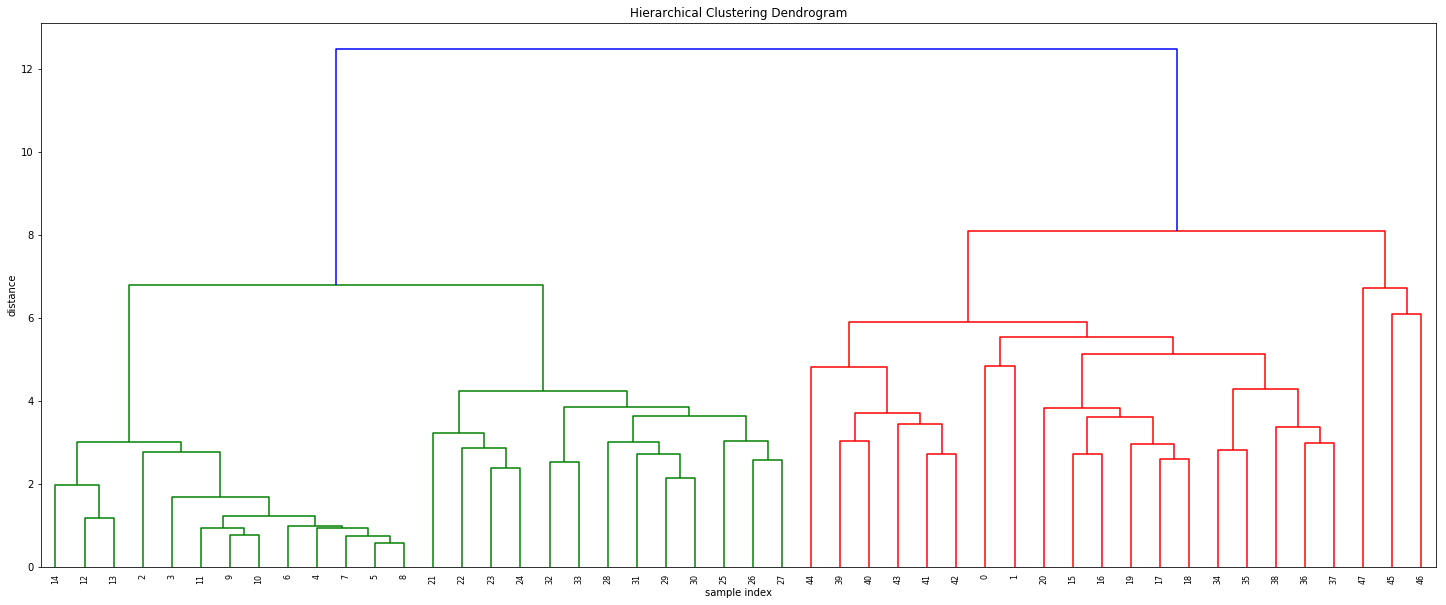

In [22]:
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z,
           leaf_rotation=90., #rotates the x-axis labels
           leaf_font_size=8., #font size for the x axis labels
)
plt.show()

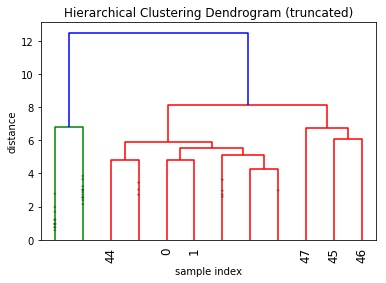

In [20]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.show()